## Code for computing the structure function (given a light curve)
In this demonstration, we will use the following definition for SF:

$$\operatorname{SF}^{2}(\Delta t)=\frac{1}{P} \sum_{i, j>i}^{P}\left(m_{i}-m_{j}\right)^{2}-\sigma_{i}^{2}-\sigma_{j}^{2}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# eztao for simulation DRW
from eztao.carma import DRW_term
from eztao.ts import gpSimRand

### 1. Develop using Gaussian random noise

In [2]:
# generate gaussian random time series
size=1000
t = np.random.uniform(size=size)*3000
t = t[np.argsort(t)]
y = np.random.normal(scale=1, size=size)[np.argsort(t)]
yerr = np.random.normal(scale=0.05, size=size)[np.argsort(t)]

<ErrorbarContainer object of 3 artists>

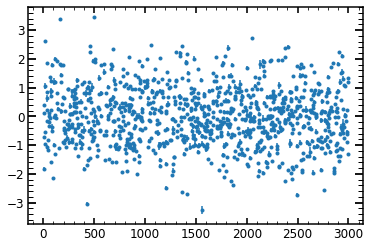

In [3]:
# viz the 'LC'
plt.errorbar(t, y, yerr, fmt='.')

In [4]:
## compute dt and dm for all gaps
# dt
dt_matrix = t.reshape((1, t.size)) - t.reshape((t.size, 1))
dts = dt_matrix[dt_matrix > 0].flatten().astype(np.float16)

# dm
dm_matrix = y.reshape((1, y.size)) - y.reshape((y.size, 1))
dms = dm_matrix[dt_matrix > 0].flatten().astype(np.float16)

# err^2
err2_matrix = yerr.reshape((1, yerr.size))**2 + yerr.reshape((yerr.size, 1))**2
err2s = err2_matrix[dt_matrix > 0].flatten().astype(np.float16)

In [5]:
## SF for each pair of observations, will give underflow error given limited precision
sfs = dms**2 - err2s

/var/folders/t5/wsx3rfv52lj4xzmnd7ywbq0h0000gn/T/ipykernel_20917/3706756829.py:2: RuntimeWarning: underflow encountered in square
  sfs = dms**2 - err2s


In [6]:
## bin sfs by dts using log_dt bins
max_dt = 3500 # arbitrary
log_bins = np.logspace(np.log10(dts.min())-0.1, np.log10(max_dt)+0.1, 50)

# the line below will throw error if the bins are not covering the whole range
SFs, bin_edgs, _ = binned_statistic(dts, sfs, 'mean', log_bins)

/opt/miniconda3/envs/env_var/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


Text(0.5, 1.0, 'SF for a gaussian white noise')

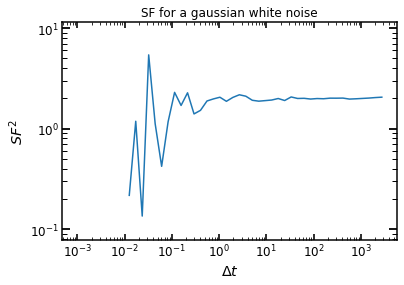

In [7]:
bin_cents = (bin_edgs[0:-1] + bin_edgs[1:])/2
plt.loglog(bin_cents, SFs)
plt.xlabel('$\Delta t$')
plt.ylabel('$SF^2$')
plt.title('SF for a gaussian white noise')

### 2. Test on simulated DRW

In [8]:
amp = 0.2
tau = 100
DRW_kernel = DRW_term(np.log(amp), np.log(tau))
t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 1000)

<ErrorbarContainer object of 3 artists>

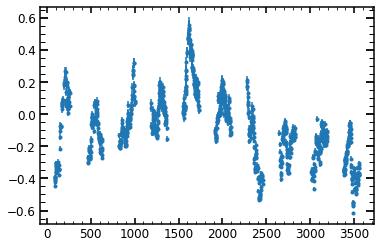

In [9]:
# vis drw lc
plt.errorbar(t, y, yerr, fmt='.')

In [16]:
def sf2(t, y, yerr, bins):
    """Calculate structure function squared

    Short description goes here

    Parameters
    ----------
    t : `np.array` [`float`]
        Times at which the measurment was conducted
    y : `np.array` [`float`]
        Measurment values
    yerr : `np.array` [`float`]
        Measurment errors
    bins:  `np.array` [`float`]

    Returns
    ----------
    SF, bin_edge : 
    
    Notes
    ----------
   
    TODO:
    ----------
    - allow user to not specify bins - automatically assume ``reasonable bins''
    - allow user to not specify times - assume equivdistant times
    - allow multiple inputs, with same <t> at once
    - ability to create SF2 from multiple lightcurves at once (ensamble)
    - allow for different definition of SF2
    
    """
    
    
    
    ## compute dt and dm for all gaps
    # dt
    dt_matrix = t.reshape((1, t.size)) - t.reshape((t.size, 1))
    dts = dt_matrix[dt_matrix > 0].flatten().astype(np.float16)

    # dm
    dm_matrix = y.reshape((1, y.size)) - y.reshape((y.size, 1))
    dms = dm_matrix[dt_matrix > 0].flatten().astype(np.float16)

    # err^2
    err2_matrix = yerr.reshape((1, yerr.size))**2 + yerr.reshape((yerr.size, 1))**2
    err2s = err2_matrix[dt_matrix > 0].flatten().astype(np.float16)
    
    ## SF for each pair of observations
    sfs = dms**2 - err2s
    
    # SF for at specific dt
    # the line below will throw error if the bins are not covering the whole range
    SFs, bin_edgs, _ = binned_statistic(dts, sfs, 'mean', bins)

    return SFs, (bin_edgs[0:-1] + bin_edgs[1:])/2

In [11]:
min_dt = np.diff(t).min()
max_dt = t[-1] - t[0]
log_bins = np.logspace(np.log10(min_dt)-0.1, np.log10(max_dt)+0.1, 20)

#### Compute SF^2 and plot

/var/folders/t5/wsx3rfv52lj4xzmnd7ywbq0h0000gn/T/ipykernel_20917/662824668.py:44: RuntimeWarning: underflow encountered in square
  sfs = dms**2 - err2s
/opt/miniconda3/envs/env_var/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


Text(0.5, 1.0, 'SF for a DRW')

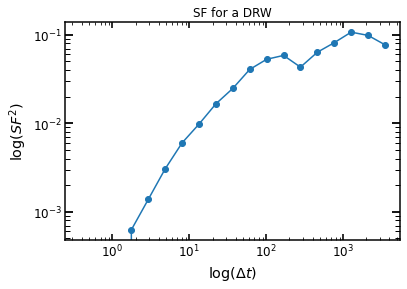

In [20]:
SF, b_cent = sf2(t, y, yerr, log_bins) 
plt.loglog(b_cent, SF,marker = 'o')
plt.xlabel('log($\Delta t$)')
plt.ylabel('log($SF^2$)')
plt.title('SF for a DRW')

In [13]:
SF

array([-5.65423372e-04, -3.26299667e-04, -8.92425406e-06,  6.25777779e-04,
        1.38135530e-03,  3.05483643e-03,  6.00859786e-03,  9.79027157e-03,
        1.66031169e-02,  2.48092718e-02,  4.06543196e-02,  5.29314196e-02,
        5.85664945e-02,  4.31641467e-02,  6.36380416e-02,  8.16119415e-02,
        1.07314004e-01,  9.85682142e-02,  7.72408728e-02])

In [14]:
b_cent

array([3.8550e-01, 6.3965e-01, 1.0615e+00, 1.7607e+00, 2.9219e+00,
       4.8438e+00, 8.0391e+00, 1.3336e+01, 2.2125e+01, 3.6719e+01,
       6.0906e+01, 1.0106e+02, 1.6775e+02, 2.7825e+02, 4.6150e+02,
       7.6600e+02, 1.2700e+03, 2.1080e+03, 3.4960e+03], dtype=float16)

In [19]:
log_bins

array([2.89958802e-01, 4.81068432e-01, 7.98136961e-01, 1.32418293e+00,
       2.19694179e+00, 3.64492934e+00, 6.04727442e+00, 1.00329868e+01,
       1.66456517e+01, 2.76166736e+01, 4.58186122e+01, 7.60173095e+01,
       1.26119737e+02, 2.09244293e+02, 3.47155607e+02, 5.75963216e+02,
       9.55576172e+02, 1.58538913e+03, 2.63030699e+03, 4.36392223e+03])